In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
 #   for filename in filenames:
  #      print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install torch_snippets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 60.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 53.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 6.5 MB/s eta 0:00:00
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26304 sha256=6adcf44e7ee511355e35e501b07aa877460f600933704ace681cf002b1bcd813
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typing
  Attempting uninstall: platformdirs
    Found existing installation: platformdirs 4.1.0
    Uninstalling platformdirs-4.1.0:
      Successfully uninstalled platformdirs-4.1.0
ERR

In [3]:
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2 
import glob

In [4]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])


In [5]:
train_images=sorted(glob.glob("/kaggle/input/kitti-roadlane-detection-dataset-224-x-224/data_road_224/training/image_2/*.png"))
train_mask=sorted(glob.glob("/kaggle/input/kitti-roadlane-detection-dataset-224-x-224/data_road_224/training/gt_image_2/*.png"))
test_images=sorted(glob.glob("/kaggle/input/kitti-roadlane-detection-dataset-224-x-224/data_road_224/testing/image_2/*.png"))

In [6]:
class SegData(Dataset):
    def __init__(self,images,labels):
        self.images=images
        self.labels=labels
    def __len__(self):
        return len(self.images)
    def __getitem__(self, ix):
        image = cv2.imread(self.images[ix])
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224,224))
        mask = read(self.labels[ix])
        mask = cv2.resize(mask, (224,224))
        #mask=cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
        return image, mask
    def choose(self): return self[randint(len(self.images))]
    def __len__(self):
        return len(self.images)
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([transforms.ToTensor()(mask)[None] for mask in masks]).float().to(device)
        return ims, ce_masks

In [7]:
train_dataset=SegData(train_images,train_mask)
#test_dataset=SegData(test_images,test_mask)

(224, 224, 3)

(224, 224, 3)

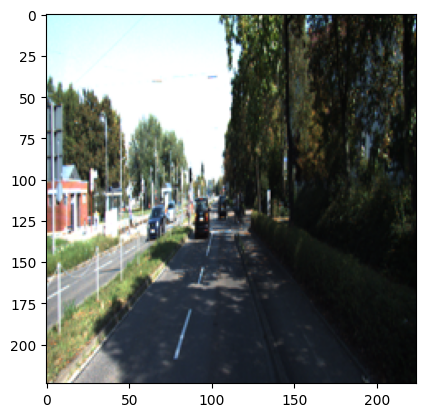

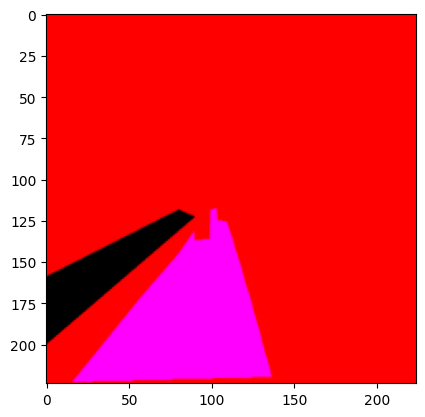

In [8]:
image,mask=train_dataset[100]
print(image.shape)
print(mask.shape)
plt.imshow(image)
plt.figure()
plt.imshow(mask)


In [9]:
trn_dl = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=train_dataset.collate_fn,drop_last=True)
#test_dl=DataLoader(test_dataset,batch_size=4,shuffle=True,collate_fn=test_dataset.collate_fn)

In [10]:
_,mask=next(iter(trn_dl))
mask.shape

torch.Size([4, 3, 224, 224])

In [11]:
def conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=(3,3),padding="same"),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
def up_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [12]:
class tinyUNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=32):
        super().__init__()
        self.block1=conv(3,64)
        self.block2=conv(64,64)
        self.block3=conv(64,128)
        self.block4=conv(128,128)
        self.block5=conv(128,256)
        self.block6=conv(256,256)
        self.block7=conv(256,512)
        self.block8=conv(512,512)
        self.block9=conv(512,1024)
        self.maxpool=nn.MaxPool2d(kernel_size=(2,2),stride=2,padding=0,dilation=1,ceil_mode=False)
        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256+256,256)
        self.up_conv8 = up_conv(128+128, 128)
        self.conv8 = conv(128 + 128, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 +64, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(64, 3, kernel_size=1)
        self.sigmoid=nn.Sigmoid()
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.maxpool(self.block2(block1))
        block3 = self.block3(block2)
        block4 = self.maxpool(self.block4(block3))
        block5 = self.block5(block4)
        block6 = self.maxpool(self.block6(block5))
        block7 = self.block7(block6)
        block8 = self.maxpool(self.block8(block7))
        block9=self.block9(block8)

        x4 = self.up_conv6(block9)
        x4 = torch.cat([x4,block7],dim=1)
        x4=self.conv6(x4)
        x3 = self.up_conv7(x4)
        
        x3 = torch.cat([x3, block5], dim=1)
        x3 = self.conv7(x3)

        x2 = self.up_conv8(x3)
        x2 = torch.cat([x2, block3], dim=1)
        x2 = self.conv8(x2)

        x1 = self.up_conv9(x2)
        x1 = torch.cat([x1, block1], dim=1)
        x1 = self.conv9(x1)

        #x = self.up_conv10(x1)
        #x = torch.cat([x, block1], dim=1)
        #x = self.conv10(x)

        x = self.sigmoid(self.conv11(x1))

        return x

In [13]:
model=tinyUNet().to(device)

In [14]:
!pip install torchsummary

In [15]:
from torchsummary import summary
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
            Conv2d-4         [-1, 64, 224, 224]          36,928
       BatchNorm2d-5         [-1, 64, 224, 224]             128
              ReLU-6         [-1, 64, 224, 224]               0
         MaxPool2d-7         [-1, 64, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]          73,856
       BatchNorm2d-9        [-1, 128, 112, 112]             256
             ReLU-10        [-1, 128, 112, 112]               0
           Conv2d-11        [-1, 128, 112, 112]         147,584
      BatchNorm2d-12        [-1, 128, 112, 112]             256
             ReLU-13        [-1, 128, 112, 112]               0
        MaxPool2d-14          [-1, 128,

In [16]:
loss_fn=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4,weight_decay=1e-7)

In [17]:
def train_batch(model, data):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss=loss_fn(_masks,ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def validate_batch(model, data):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss=loss_fn(_masks,masks)
    return loss.item()

In [18]:
n_epochs=20
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss= train_batch(model, data)
        log.record(ex+(bx+1)/N, trn_loss=loss, end='\r')
    log.report_avgs(ex+1)

EPOCH: 1.000  trn_loss: 0.167  (9.44s - 179.33s remaining)
EPOCH: 2.000  trn_loss: 0.120  (16.71s - 150.35s remaining)
EPOCH: 3.000  trn_loss: 0.098  (23.99s - 135.92s remaining)
EPOCH: 4.000  trn_loss: 0.080  (31.18s - 124.72s remaining)
EPOCH: 5.000  trn_loss: 0.067  (38.38s - 115.14s remaining)
EPOCH: 6.000  trn_loss: 0.056  (45.57s - 106.34s remaining)
EPOCH: 7.000  trn_loss: 0.047  (52.76s - 97.99s remaining))
EPOCH: 8.000  trn_loss: 0.040  (60.00s - 90.00s remaining)
EPOCH: 9.000  trn_loss: 0.034  (67.22s - 82.15s remaining)
EPOCH: 10.000  trn_loss: 0.029  (74.53s - 74.53s remaining)
EPOCH: 11.000  trn_loss: 0.025  (81.78s - 66.91s remaining)
EPOCH: 12.000  trn_loss: 0.022  (88.99s - 59.33s remaining)
EPOCH: 13.000  trn_loss: 0.019  (96.16s - 51.78s remaining)
EPOCH: 14.000  trn_loss: 0.018  (103.35s - 44.29s remaining)
EPOCH: 15.000  trn_loss: 0.016  (110.55s - 36.85s remaining)
EPOCH: 16.000  trn_loss: 0.015  (117.79s - 29.45s remaining)
EPOCH: 17.000  trn_loss: 0.013  (125.04s

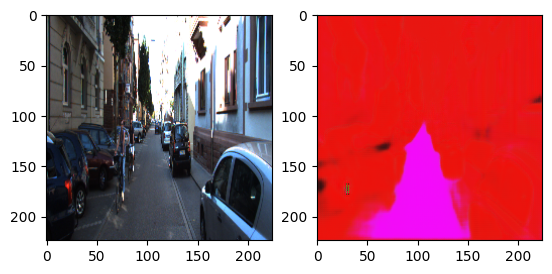

In [19]:
image=cv2.imread(test_images[-7])
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image=cv2.resize(image,(224,224))
image_tensor=tfms(image/255.)[None].float().to(device)
with torch.no_grad():
    mask=model(image_tensor)
mask=mask[0].detach().permute(1,2,0).cpu()
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(mask)

In [20]:
PATH = "Kitty_lane_detector.pt"
torch.save(model.state_dict(), PATH)

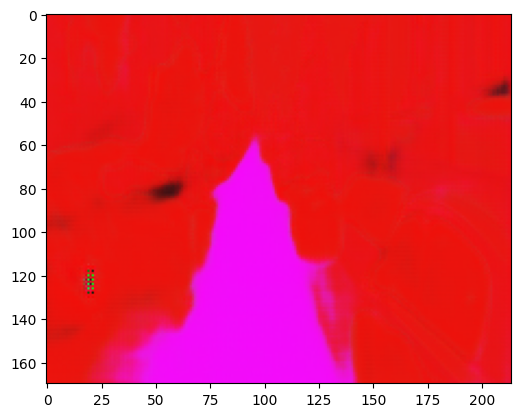

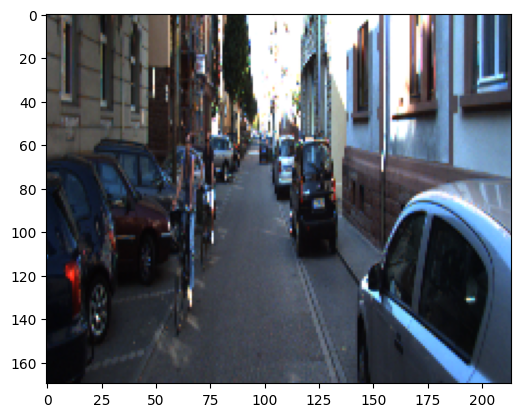

In [21]:
mask_img=np.round(255*mask.numpy()).astype(np.uint8)
#roi=mask_img
roi=mask_img[50:220,10:,:]
image=image[50:220,10:,:]
plt.imshow(roi)
plt.figure()
plt.imshow(image)

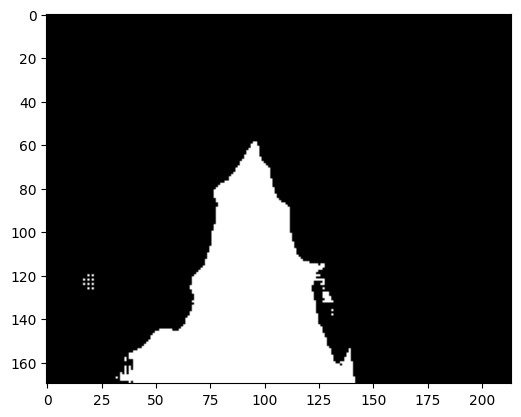

In [22]:
#high_pink=np.array([255,0,255])
#low_pink=np.array([147,112,219])
#mask_thresh=cv2.inRange(mask_img,high_pink,low_pink)
#plt.imshow(mask_thresh)
mask_gray=cv2.cvtColor(roi,cv2.COLOR_RGB2GRAY)
gray=cv2.GaussianBlur(mask_gray,(5,5),0)
ret,thresh=cv2.threshold(mask_gray,100,255,cv2.THRESH_BINARY)
plt.imshow(thresh,cmap='gray')

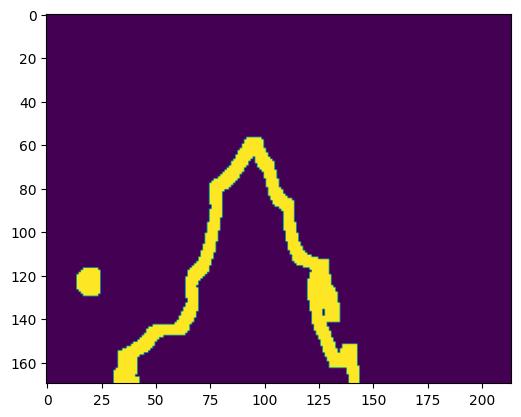

In [23]:
canny=cv2.Canny(np.array(thresh,dtype=np.uint8),50,255,apertureSize=7)
canny=cv2.dilate(canny,np.ones((5,5)),iterations = 1)

plt.imshow(canny)

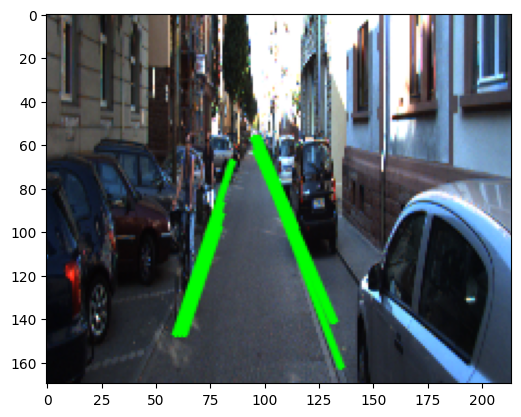

In [24]:
lines=cv2.HoughLinesP(canny,2,np.pi/180,threshold=100, lines=np.array([]), minLineLength=40, maxLineGap=5)
if lines is not None:
    for line in lines:
        for x1,y1,x2,y2 in line:
        #ROI=np.array([(x1,y1),((x1+x2)/2,(y2-y1)/2),(x2,y2)],np.int32)
        #lanes=cv2.fillPoly(mask,[ROI],(255,255,255))
            lanes=cv2.line(image,(x1,y1),(x2,y2),(0,255,0),2,cv2.LINE_AA)
    plt.imshow(lanes)
else: 
    print("the is no line")

In [25]:
def make_coordinates(coords):
    y=image.shape[0]
    y2=int(y*(3/5))
    m,b=coords[0],coords[1]
    x=(y-b)/m
    x2=(y2-b)/m
    return np.array([x,y,x2,y2])

def average_lines(lines):
    left_fit=[]
    right_fit=[]
    for line in lines:
            x1,y1,x2,y2=line.reshape(4)
            parameters=np.polyfit((x1,x2),(y1,y2),1)
            slopes=parameters[0]
            intercep=parameters[1]
            if slopes<0:
                left_fit.append((slopes,intercep))
            else:
                right_fit.append((slopes,intercep))
    left_average=np.average(left_fit,axis=0)
    right_average=np.average(right_fit,axis=0)
    left_coords=make_coordinates(left_average)
    right_coords=make_coordinates(right_average)
    return np.array([left_coords,right_coords],dtype=np.int32)


[ 53 170  75 102]

[142 170 114 102]

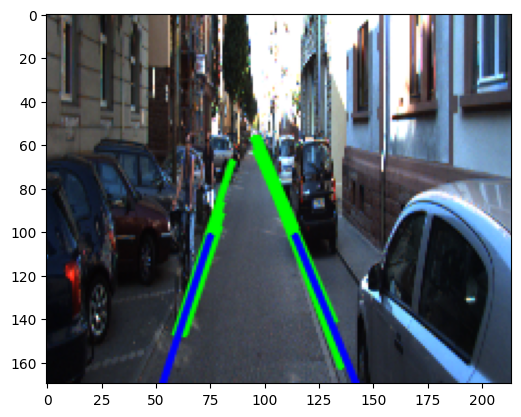

In [26]:
avg_line=average_lines(lines)
if avg_line is not None:
    for line in avg_line:
        x1,y1,x2,y2=line.reshape(4)
        print(line)
        #ROI=np.array([(x1,y1),((x1+x2)/2,(y2-y1)/2),(x2,y2)],np.int32)
        #lanes=cv2.fillPoly(mask,[ROI],(255,255,255))
        lanes=cv2.line(image,(x1,y1),(x2,y2),(0,0,255),2,cv2.LINE_AA)
    plt.imshow(lanes)
else: 
    print("the is no line")

In [27]:
# Steering Angle
h,w=image.shape[:2]
def compute_steering_angle(avg_line):
    if avg_line is not None and len(avg_line)==2 :
        theta=0
        _,_,x1,_=avg_line[0]
        _,_,x2,_=avg_line[1]
        theta=theta+np.arctan(((x2+x1)/2-int(w/2))/int(h*(3/5)))
        rad=np.rad2deg(theta)+90
    elif avg_line is None:
        theta=0
        theta=theta+np.arctan2(0,int(h/2))
        rad=np.rad2deg(theta)
    else:
        theta=0
        for avg_line in avg_line:
            for x1,y1,x2,y2 in line:
                theta=theta+np.arctan((x2-x1)/(y2-y1))
                rad=np.rad2deg(theta)+90
    print(rad-90)
    print(theta)

In [28]:
compute_steering_angle(avg_line)

-6.9867045366669345

-0.12194099802886278

In [29]:
def predict_lanes(image):
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image=cv2.resize(image,(224,224))
    image_tensor=tfms(image/255.)[None].float().to(device)
    with torch.no_grad():
        mask=model(image_tensor)
    mask=mask[0].detach().permute(1,2,0).cpu()
    mask_img=np.round(255*mask.numpy()).astype(np.uint8)
    #roi=mask_img
    roi=mask_img[50:220,10:,:]
    image=image[50:220,10:,:]
    mask_gray=cv2.cvtColor(roi,cv2.COLOR_RGB2GRAY)
    gray=cv2.GaussianBlur(mask_gray,(5,5),0)
    ret,thresh=cv2.threshold(mask_gray,100,255,cv2.THRESH_BINARY)
    canny=cv2.Canny(np.array(thresh,dtype=np.uint8),50,255,apertureSize=7)
    canny=cv2.dilate(canny,np.ones((5,5)),iterations = 1)
    lines=cv2.HoughLinesP(canny,2,np.pi/180,threshold=100, lines=np.array([]), minLineLength=40, maxLineGap=5)
    avg_line=average_lines(lines)
    if avg_line is not None:
        for line in avg_line:
            x1,y1,x2,y2=line.reshape(4)
        #lanes=cv2.fillPoly(mask,[ROI],(255,255,255))
            lanes=cv2.line(image,(int(x1),int(y1)),(int(x2),int(y2)),(0,255,0),3,cv2.LINE_AA)
        plt.imshow(lanes)
    else: 
        print("the is no line")
    plt.figure()
    plt.imshow(roi)
    compute_steering_angle(avg_line)
    

-27.677450793375783

-0.48306264490312417

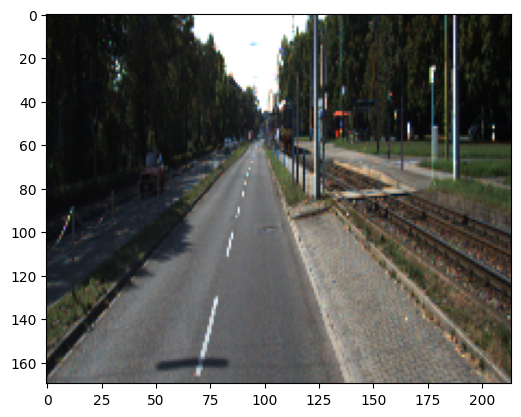

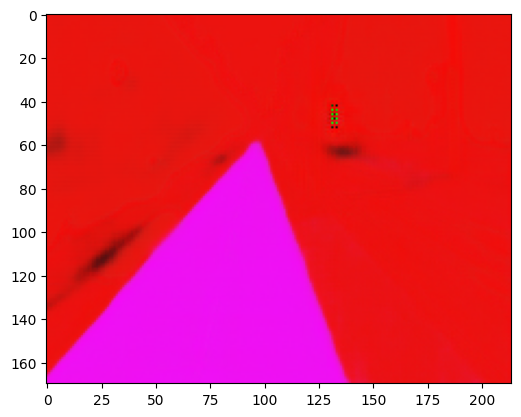

In [30]:
image=cv2.imread(test_images[1])
predict_lanes(image)